In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append('..')
from utils import featurize, update_vars
import scanpy as sc
from modules.vae import JointVAE
from torch import optim
from modules.losses import Loss
from early_stopping import EarlyStopping
from tqdm import tqdm
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from scipy.stats import spearmanr
import squidpy as sq
import math
from leiden_clustering import LeidenClustering
from anndata import AnnData
import pandas as pd
from sklearn.decomposition import PCA
from utils import train_test_split
from modules.losses import Metrics
from modules.losses import LossFunctions
from plotting import plot_latent
from utils import euclidean_distance
from plotting import plot_latent
assert torch.cuda.is_available()
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import re, seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

In [66]:
from anndata import AnnData

In [7]:
import uniport as up

In [92]:
deets = sc.read_10x_h5('/ix/hosmanbeyoglu/kor11/CytAssist/Tonsil/GEX_PEX/CytAssist_FFPE_Protein_Expression_Human_Tonsil_filtered_feature_bc_matrix.h5', gex_only=False)

In [96]:
deets[:, deets.var.feature_types=='Antibody Capture'].to_df()

,CD163,CR2,PCNA,VIM,KRT5,CD68,CEACAM8,PTPRC,HLA-DRA,PAX5,...,MS4A1,CD3E,CD14,CD40,PECAM1,CD4,ITGAM,CD27,CCR7,CD274
AACACGTGCATCGCAC-1,19675.0,35856.0,57685.0,48611.0,4606.0,26250.0,1597.0,37962.0,71921.0,19236.0,...,19282.0,44768.0,20949.0,40115.0,9282.0,99861.0,11643.0,52662.0,35509.0,5625.0
AACACTTGGCAAGGAA-1,23938.0,35784.0,76953.0,16984.0,2430.0,56707.0,2584.0,41353.0,79569.0,22307.0,...,57292.0,30923.0,14707.0,41969.0,5846.0,76646.0,25692.0,37846.0,27600.0,8738.0
AACAGGAAGAGCATAG-1,20784.0,34129.0,82150.0,43890.0,887.0,31808.0,1331.0,36791.0,76382.0,15904.0,...,27542.0,52457.0,19283.0,38327.0,7269.0,104368.0,21604.0,57542.0,35529.0,9044.0
AACAGGATTCATAGTT-1,21530.0,29744.0,27397.0,21581.0,96836.0,26454.0,10025.0,33928.0,51377.0,8188.0,...,22959.0,13979.0,16147.0,34668.0,9642.0,72551.0,10765.0,33903.0,31607.0,27959.0
AACAGGCCAACGATTA-1,23276.0,24124.0,23841.0,19548.0,105734.0,29689.0,19096.0,18418.0,20677.0,3870.0,...,8700.0,15508.0,15875.0,22966.0,6412.0,67485.0,8954.0,29039.0,34604.0,5423.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGTTGGAACCTTCCGC-1,15675.0,28426.0,20143.0,41764.0,3799.0,22734.0,6740.0,40111.0,84276.0,3847.0,...,15723.0,108569.0,19523.0,30429.0,22082.0,120985.0,6947.0,69300.0,42607.0,9189.0
TGTTGGAACGAGGTCA-1,18200.0,29031.0,31915.0,55578.0,3378.0,14747.0,2305.0,44063.0,29157.0,2800.0,...,9568.0,252115.0,16989.0,25757.0,7800.0,150105.0,4589.0,86905.0,91821.0,9168.0
TGTTGGAAGCTCGGTA-1,26111.0,29764.0,35897.0,67521.0,4230.0,18076.0,2564.0,40512.0,35106.0,4914.0,...,9871.0,102094.0,19380.0,31730.0,8461.0,91196.0,3696.0,63354.0,48076.0,5235.0
TGTTGGATGGACTTCT-1,17995.0,29608.0,13777.0,15678.0,21461.0,16613.0,1996.0,19752.0,28442.0,5870.0,...,9305.0,16014.0,17571.0,26605.0,10615.0,79345.0,4880.0,36597.0,24856.0,5183.0


In [8]:
# https://cellxgene.cziscience.com/collections/4195ab4c-20bd-4cd3-8b3d-65601277e731

In [47]:
adata = sc.read_visium(path='/ix/hosmanbeyoglu/kor11/CytAssist/Breast/GEX_PEX')
adata6 = sc.read_h5ad('/ix/hosmanbeyoglu/kor11/CytAssist/Breast/visium/patient_6.h5ad')

In [37]:
adata.var_names_make_unique()
adata6.var_names_make_unique()

adata.obsm['spatial'] = adata.obsm['spatial'].astype(float)
adata6.obsm['spatial'] = adata6.obsm['spatial'].astype(float)

In [38]:
adata.obs['source'] = 'Breast CytAssist (Ref)'
adata.obs['domain_id'] = 0
adata.obs['source'] = adata.obs['source'].astype('category')
adata.obs['domain_id'] = adata.obs['domain_id'].astype('category')

adata6.obs['source'] = 'Breast Sample 6'
adata6.obs['domain_id'] = 1
adata6.obs['source'] = adata6.obs['source'].astype('category')
adata6.obs['domain_id'] = adata6.obs['domain_id'].astype('category')

In [39]:
adata6.var_names = adata6.var.feature_name.values

In [40]:
adata_cm = AnnData.concatenate(adata, adata6, join='inner')

In [41]:
sc.pp.normalize_total(adata_cm)
sc.pp.log1p(adata_cm)
sc.pp.highly_variable_genes(adata_cm, n_top_genes=5000, inplace=False, subset=True)
up.batch_scale(adata_cm)

In [42]:
adata = adata_cm[adata_cm.obs.domain_id==0]
adata6 = adata_cm[adata_cm.obs.domain_id==1]

In [43]:
adata.shape, adata6.shape

((4169, 5000), (3037, 5000))

In [44]:
adata_cm = AnnData.concatenate(adata, adata6, join='inner')
adatax = up.Run(adatas=[adata, adata6], adata_cm=adata_cm, lambda_s=1.0, ref_id=1)

Device: cuda
Dataset 0: Breast CytAssist (Ref)
View of AnnData object with n_obs × n_vars = 4169 × 5000
    obs: 'in_tissue', 'array_row', 'array_col', 'source', 'domain_id', 'mapped_reference_assembly', 'mapped_reference_annotation', 'alignment_software', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'donor_living_at_sample_collection', 'donor_menopausal_status', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'sample_derivation_process', 'sample_source', 'donor_BMI_at_collection', 'tissue_section_uuid', 'tissue_section_thickness', 'library_uuid', 'assay_ontology_term_id', 'sequencing_platform', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'sex_ontology_term_id', 'nCount_Spatial', 'nFeature_Spatial', 'nCount_SCT', 'nFeature_SCT', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity'

Epochs: 100%|██████████| 1072/1072 [25:07<00:00,  1.41s/it, recloss=980.20,klloss=8.30,otloss=7.91]    


... storing 'in_tissue' as categorical
... storing 'array_row' as categorical
... storing 'array_col' as categorical
... storing 'feature_types-0' as categorical
... storing 'genome-0' as categorical


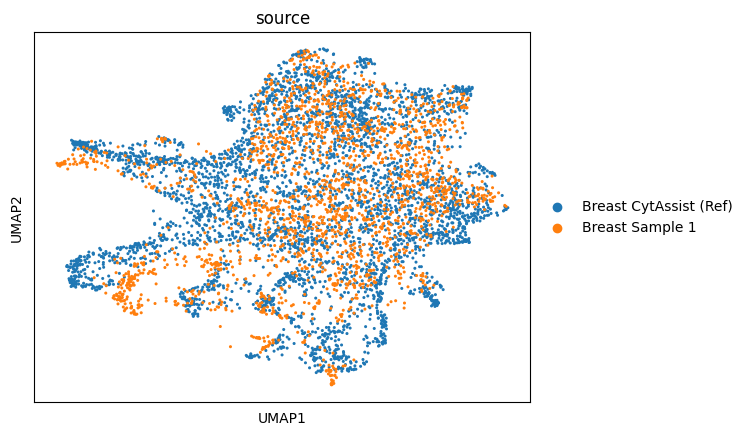

In [507]:
sc.pp.neighbors(adatax, use_rep='latent')
sc.tl.umap(adatax, min_dist=0.2)
sc.pl.umap(adatax, color=['source'])

In [508]:
adata3 = sc.read_h5ad('/ix/hosmanbeyoglu/kor11/CytAssist/Breast/visium/patient2.h5ad')
adata3.obs['source'] = 'Breast Sample 2'
adata3.obs['domain_id'] = 2
adata3.obs['source'] = adata3.obs['source'].astype('category')
adata3.obs['domain_id'] = adata3.obs['domain_id'].astype('category')

In [509]:
sc.pp.normalize_total(adata3)
sc.pp.log1p(adata3)
up.batch_scale(adata3)

In [510]:
adata3.var_names = adata3.var.feature_name.values

In [512]:
adata_cm = AnnData.concatenate(adata3, adata, join='inner')
adata_new = up.Run(adatas=[adata3, adata], adata_cm =adata_cm, lambda_s=1.0, out='project', ref_id=1)
adata3.obsm['latent'] = adata_new[adata_new.obs.domain_id==2].obsm['project']

Device: cuda


In [513]:
adatax = adatax.concatenate(adata3, join='inner')

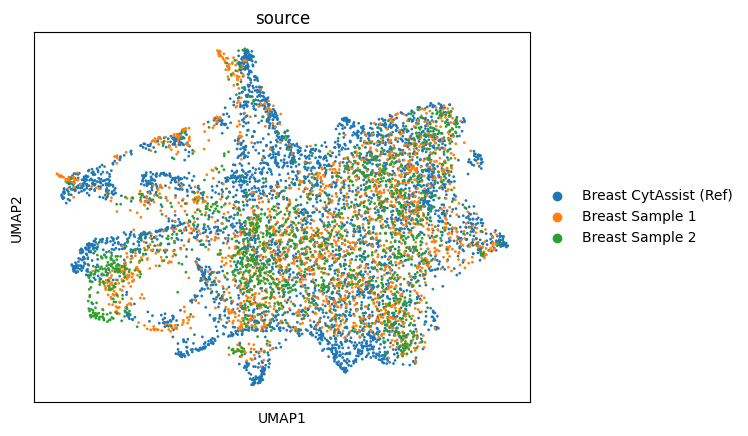

In [515]:
sc.pp.neighbors(adatax, use_rep='latent')
sc.tl.umap(adatax, min_dist=0.2)
sc.pl.umap(adatax, color=['source'])

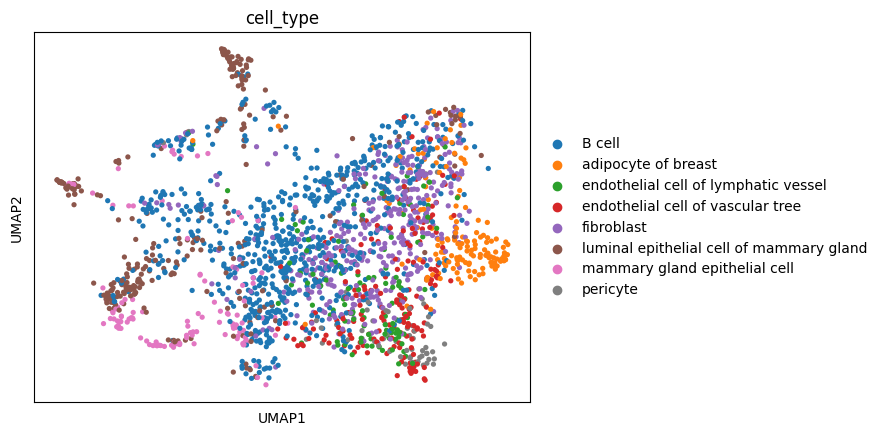

In [516]:
sc.pl.umap(adatax[adatax.obs.domain_id==1], color=['cell_type'])

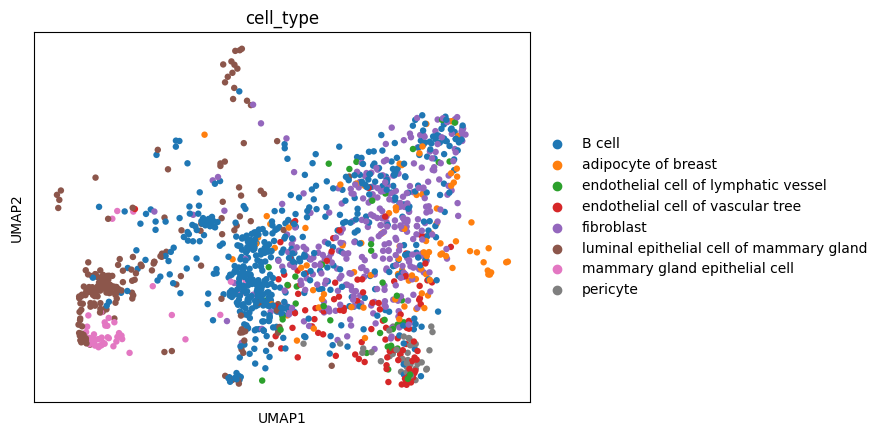

In [517]:
sc.pl.umap(adatax[adatax.obs.domain_id==2], color=['cell_type'])

In [520]:
import cuml

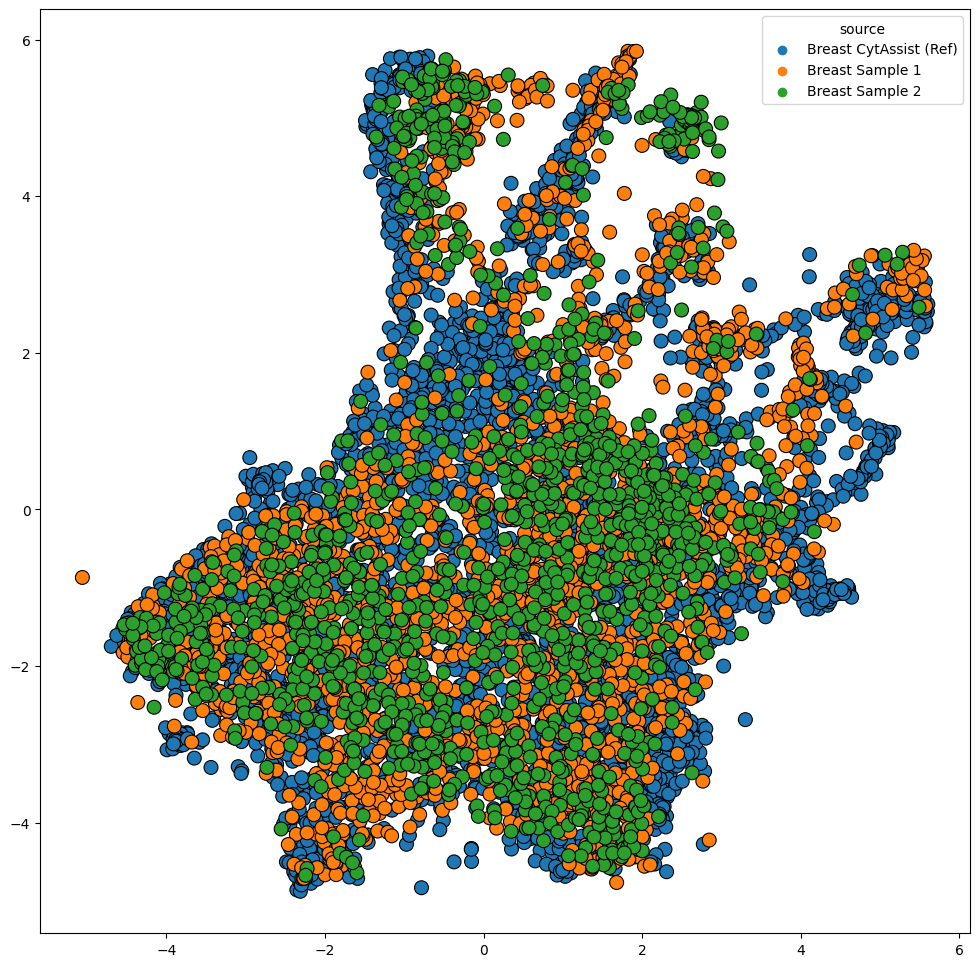

In [534]:
plt.rcParams['figure.figsize'] = [12, 12]
red = cuml.UMAP(
    n_components=2,
    n_neighbors=20,
    min_dist=.1,
    random_state=42
)
red.fit(adatax.obsm['latent'])
plot_data = red.transform(adatax.obsm['latent'])
sns.scatterplot(plot_data[:, 0], plot_data[:, 1], hue=adatax.obs.source, edgecolor='black', s=100)
plt.show()